In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lfilter
from scipy import signal
import math

In [2]:
def import_data(file_loc, truncate=True, debug = False):
    captured_data = np.load(file_loc)
    input0_offset=np.argmax((captured_data[0]>0).astype(int))
    input1_offset=np.argmax((captured_data[1]>0).astype(int))
    output0_offset=np.argmax((captured_data[2]>0).astype(int))
    output1_offset=np.argmax((captured_data[3]>0).astype(int))
    
    # Truncate to 12 bits from 16, but store in 16 MSB aligned
    input0 = captured_data[0]
    input1 = captured_data[1]
    if(truncate):
        input0 = np.right_shift(input0,4)
        input0 = np.left_shift(input0,4).astype(np.int16)
        
        input1 = np.right_shift(input1,4)
        input1 = np.left_shift(input1,4).astype(np.int16)

    output0 = captured_data[2]
    output1 = captured_data[3]

    if(debug):
        print("input0_offset: %s"%(input0_offset))
        print("input1_offset: %s"%(input1_offset))
        print("output0_offset: %s"%(output0_offset))
        print("output1_offset: %s"%(output1_offset))

        print("input0_offset%%8: %s"%(input0_offset%8))
        print("input1_offset%%8: %s"%(input1_offset%8))
        print("output0_offset%%8: %s"%(output0_offset%8))
        print("output1_offset%%8: %s"%(output1_offset%8))

        print("input 0 first value: %s"%input0[input0_offset])
        print("input 1 first value: %s"%input1[input1_offset])
    
    return (input0, input1, output0, output1, input0_offset, input1_offset, output0_offset, output1_offset)

# Simulation

In [3]:
def bindigits(n, bits):
    """ https://stackoverflow.com/questions/12946116/twos-complement-binary-in-python
    Takes an integer value and number of bits, and converts to two's complement string
    Basically just masks off the number of bits. Python twos-complement are infinite length (...111111111101, for example)
    """
    s = bin(n & int("1"*bits, 2))[2:] # The [2:] cuts off the 0b of 0b######
    return ("{0:0>%s}" % (bits)).format(s)

def twos_complement_integer(n, bits):
    """ Returns two's complement representation of n as a <bits> bit number
    """
    return int(bindigits(n,bits),2)

def convert_to_fixed_point(a, a_int, a_frac, twos_complement=False):
    """Converts to an integer with <a_frac> bits of of fractional representation, and <a_int> bits of integer
    i.e. Q<a_int>.<a_frac>
    """
    if(a>=(2**(a_int-1)) or a<-1*(2**(a_int-1))):
        raise Exception("Value %s out of bounds"%a)
    # Multiply fractional bits up to integers
    # Removing digits of a twos complement goes more negative, so we mimic that in advance
    a_temp = math.floor(a * (2**a_frac))

    if(twos_complement):
        # Convert to twos complement
        a_temp = twos_complement_integer(a_temp, a_int+a_frac)
    
    return a_temp

def convert_from_fixed_point(a, a_int, a_frac, twos_complement=False):
    """Converts from a signed integer (Q<a_int>.<a_frac>) representation to a floating point
    """
    bits = a_int + a_frac
    
    if(twos_complement):
        if(a>=(2**(bits-1)) or a<-1*(2**(bits-1))):
                raise Exception("Value %s out of bounds"%a)
        # If it is signed
        if (a & (1<<(bits-1))):
            # print("Signed")
            a = (-1*(1<<(bits)) + a)
    else:
        if(a>=(2**(bits)) or a<-1*(2**(bits))):
            raise Exception("Value %s out of bounds"%a)
    a_temp = (a / (2.0**a_frac))#%(2**a_int)
    
    return a_temp

In [4]:
def multiply(a, b, a_int, a_frac, b_int, b_frac, out_int, out_frac):
    """ We are assuming that the fixed point limits of the inputs are already followed.
    This means that normal multiplication is allowed if no error is thrown."""
    a = convert_to_fixed_point(a, a_int, a_frac, twos_complement=False)
    b = convert_to_fixed_point(b, b_int, b_frac, twos_complement=False)
    result_int = a * b
    return convert_from_fixed_point(result_int, out_int, out_frac, twos_complement=False)


In [5]:
a=5.5
a_int=4
a_frac=1
b=7
b_int=4
b_frac=0
multiply(a, b, a_int, a_frac, b_int, b_frac,16,1)

38.5

In [6]:
def manual_fir_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):

    
    for coeff_set in coeffs:
        for c in coeff_set:
            if(c >= 2**18 or c < -1*(2**18)):
                raise Exception("Coefficient out of bounds")
    
    x = np.array(x)
    y = np.zeros(len(x))
    for coeff_set in coeffs:
        for i in range(len(coeff_set), len(x)):
            total = 0
            for j in range(len(coeff_set)):
                c = convert_to_fixed_point(coeff_set[j], coeff_int, coeff_frac, twos_complement=False)
                x_point = convert_to_fixed_point(x[i-j], data_int, data_frac, twos_complement=False)
                total += c * x_point
            y[i] = convert_from_fixed_point(total, out_int, out_frac, twos_complement=False)#total/(2**26)
#             if(total>0):
#                 print(total)
#                 print(y[i])
        x=np.copy(y)
        y=np.zeros(len(x))
    return x

def manual_fir_pole_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):


    # Sneaky reuse, clean up later
    return manual_fir_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int, out_frac)

    # For pole FIR
    #we get inputs in Q14.2 format. (NBITS-NFRAC, NFRAC)
    #Internally we compute in Q21.27 format, coefficients in Q4.14 format
    #So we shift to Q17.13 format.   
#     x = np.array(x)
#     y = np.zeros(len(x))
#     for coeff_set in coeffs:
#         for i in range(len(coeff_set), len(x)):
#             total = 0
#             for j in range(len(coeff_set)):
# #                 print(coeff_set[j])
#                 total += coeff_set[j] * x[i-j]
#             y[i] = total
#         x=np.copy(y)
#         y=np.zeros(len(x))
#     return x

def manual_fir_zero_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):
    # Each set of coefficients in the list is an FIR in series
    # This may need removed in the future
    
    # For zero FIR
    #coeffs in Q4.14
    #data in  Q18.12 and Q15.12
    #trim to  Q14.12 for the preadder
    #intermediate in Q22.26   
    
    # Sneaky reuse, clean up later
    return manual_fir_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int, out_frac)

def manual_fir_section(coeffs, x):
    # Each set of coefficients in the list is an FIR in series
    # This may need removed in the future
    
    # For zero FIR
    #coeffs in Q4.14
    #data in  Q18.12 and Q15.12
    #trim to  Q14.12 for the preadder
    #intermediate in Q22.26   
    
    for coeff_set in coeffs:
        for c in coeff_set:
            if(c >= 2**18 or c < -1*(2**18)):
                raise Exception("Coefficient out of bounds")
    
    x = np.array(x)
    y = np.zeros(len(x))
    for coeff_set in coeffs:
        for i in range(len(coeff_set), len(x)):
            total = 0
            for j in range(len(coeff_set)):
                total += coeff_set[j] * x[i-j]
            y[i] = total#/(2**26)
#             if(total>0):
#                 print(total)
#                 print(y[i])
        x=np.copy(y)
        y=np.zeros(len(x))
    return x

def manual_fir_pole_section(coeffs, x):
    
    # Sneaky reuse, clean up later
    return manual_fir_section(coeffs, x)

def manual_fir_zero_section(coeffs, x):
    
    # Sneaky reuse, clean up later
    return manual_fir_section(coeffs, x)


def manual_iir_section(coeffs, y):
    y = np.array(y)
    for coeff_set in coeffs:
        for i in range(len(coeff_set), len(y)):
            total = coeff_set[0] * y[i]
            for j in range(1,len(coeff_set)):
#                 print(coeff_set[j])
                total -= coeff_set[j] * y[i-j]
            y[i] = total
    return y

In [7]:
data = import_data("CaptureData/capture_240822_A_0_B_1_impulse_X1_16384_f_after.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]
known_delay = output0_offset - input0_offset - 1 # The 1 is from the delay inherent in the z^-1 of the first filter

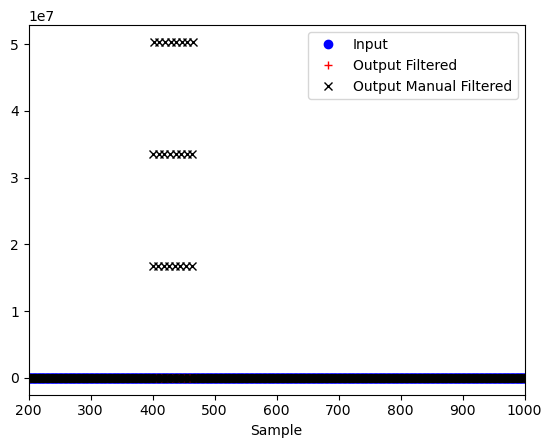

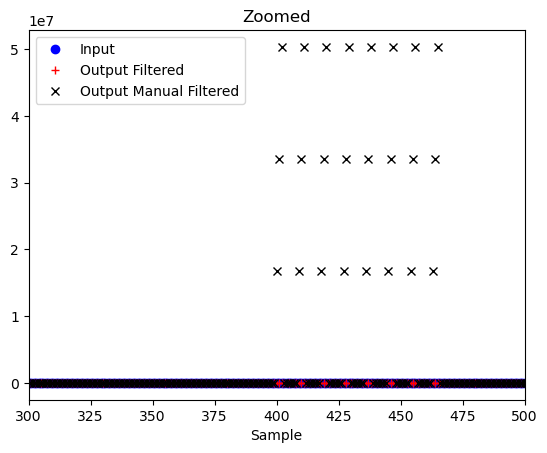

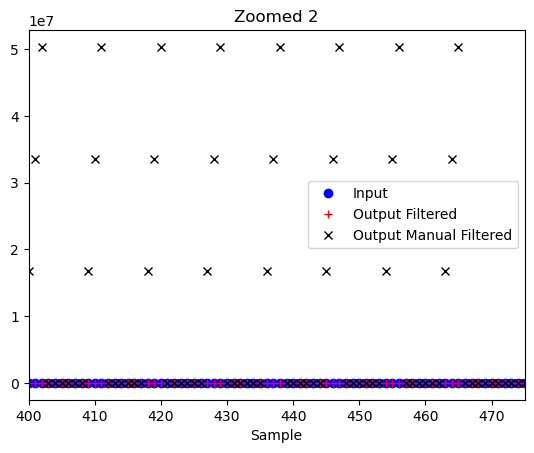

In [8]:
one_fixed = 16384 # This is 2**14, which is 1 in our Q4.14 coefficient notation

zero_coeffs = [1,2,3]
pole_coeffs = [1,0,0,0,0,0]
iir_coeffs = [1,0.9,0]

zero_fir_coeff = np.array(zero_coeffs, dtype=float)

# Zero
output0_filtered = lfilter(zero_fir_coeff, [1], input0)
output0_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_filtered)))

# The divide by 4 corrects for the two fractional (useless) bits
# The re-multiplication by one_fixed is for comparison with the scipy.signal outputs
output0_manual_filtered = manual_fir_zero_section((np.array(zero_coeffs,dtype=int)*one_fixed,),input0)/4#*one_fixed/4
output0_manual_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered)))


plt.title("")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(200,1000)
plt.show()


plt.title("Zoomed")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(300,500)
plt.show()

plt.title("Zoomed 2")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(400,475)
plt.show()


# IIR Testing

In [9]:
data = import_data("CaptureData/capture_240822_A_0_B_1_impulse_X1_16384_f_after.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]

In [10]:
known_delay = output0_offset - input0_offset - 1 # The 1 is from the delay inherent in the z^-1 of the first filter

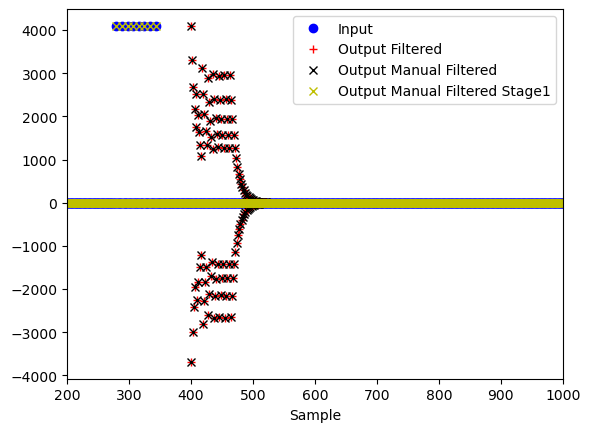

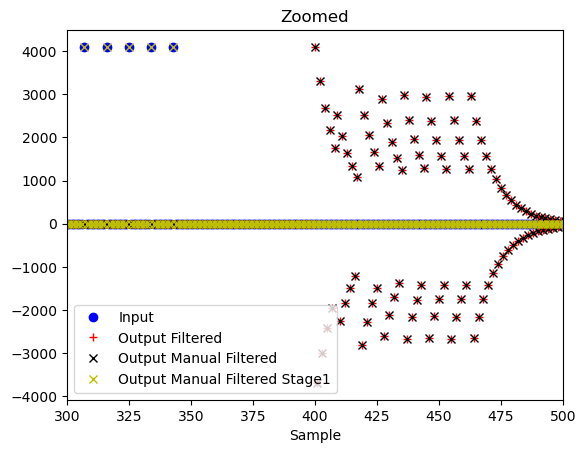

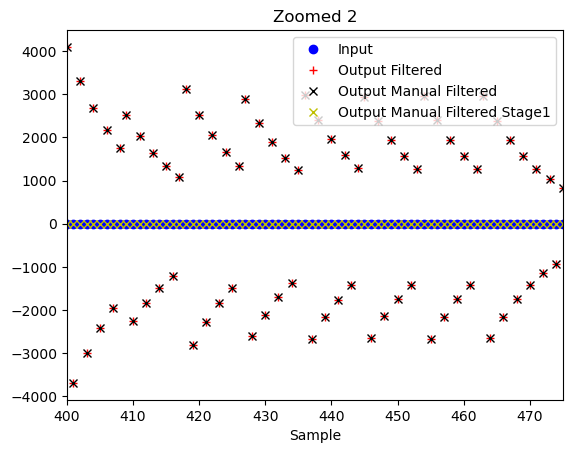

In [19]:
one_fixed = 16384
zero_coeffs = [1,0,0]
pole_coeffs = [1,0,0,0,0,0]
iir_coeffs = [1,0.9,0]

zero_fir_coeff = np.array(zero_coeffs, dtype=float)
pole_fir_coeff = np.array(pole_coeffs, dtype=float)
iir_coeff = np.array(iir_coeffs, dtype=float)

# Zero
output0_filtered_step1 = lfilter(zero_fir_coeff, [1], input0)
# Pole (including cancelling poles/zeros)
output0_filtered = lfilter(pole_fir_coeff, iir_coeff, output0_filtered_step1)
output0_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_filtered)))

# The divide by 4 corrects for the two fractional (useless) bits
# The re-multiplication by one_fixed is for comparison with the scipy.signal outputs
output0_manual_filtered_stage1 = manual_fir_section((np.array(zero_coeffs,dtype=int),np.array(pole_coeffs,dtype=int)),input0)#*one_fixed*one_fixed/16
output0_manual_filtered = manual_iir_section((iir_coeffs,),output0_manual_filtered_stage1)
output0_manual_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered)))

plt.title("")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.plot(np.array(range(len(output0_manual_filtered_stage1))), output0_manual_filtered_stage1, linestyle="None", 
         marker="x", label = "Output Manual Filtered Stage1", color="y")
plt.xlabel("Sample")
plt.legend()
plt.xlim(200,1000)
plt.show()


plt.title("Zoomed")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.plot(np.array(range(len(output0_manual_filtered_stage1))), output0_manual_filtered_stage1, linestyle="None", 
         marker="x", label = "Output Manual Filtered Stage1", color="y")
plt.xlabel("Sample")
plt.legend()
plt.xlim(300,500)
plt.show()

plt.title("Zoomed 2")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.plot(np.array(range(len(output0_manual_filtered_stage1))), output0_manual_filtered_stage1, linestyle="None", 
         marker="x", label = "Output Manual Filtered Stage1", color="y")
plt.xlabel("Sample")
plt.legend()
plt.xlim(400,475)
plt.show()


# Actual Data

In [12]:
data = import_data("CaptureData/capture_082124_A_0_B_1_impulse_Xall_16384_fg.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]

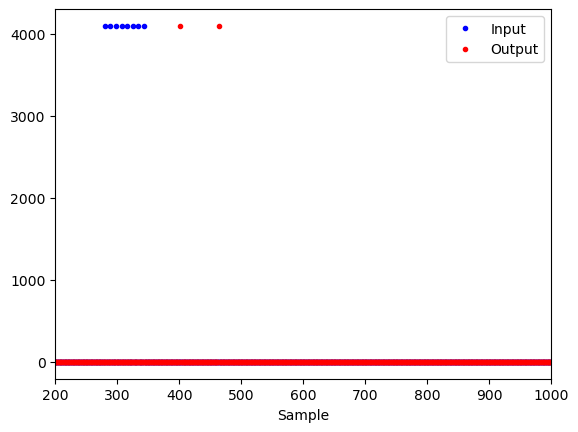

In [13]:
plt.title("")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker=".", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker=".", label = "Output", color="r")
plt.xlabel("Sample")
plt.legend()
plt.xlim(200,1000)
plt.show()

# plt.plot(np.array(range(len(captured_data[1]))), captured_data[1], linestyle="None", 
#          marker=".", label = "In ADC 1")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)
# plt.show()

# plt.title("Post Filter Out")
# plt.plot(np.array(range(len(captured_data[2]))), captured_data[2], linestyle="None", 
#          marker=".", label = "Out DAC 6")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)

# plt.plot(np.array(range(len(captured_data[3]))), captured_data[3], linestyle="None", 
#          marker=".", label = "Out DAC 7")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)
# plt.show()

# Depricated